# Code for generating 

a) Waveform without lensing

b) Lensed waveform (vanilla) without doppler shift or changes to the inclination/phase of coalescence

c) Lensed waveform with change to inclination/phase of coalescence

d) Lensed waveform with doppler shift

e) Lensed waveform with everything

# a) Waveform without lensing

In [34]:
# Import pycbc waveform and beam pattern functions
from pycbc import waveform, psd
from pycbc.detector import Detector, get_available_detectors
import pylab as plt
import numpy as np
import scienceplots
plt.style.use(['science','ieee'])

Time domain (without whitening)

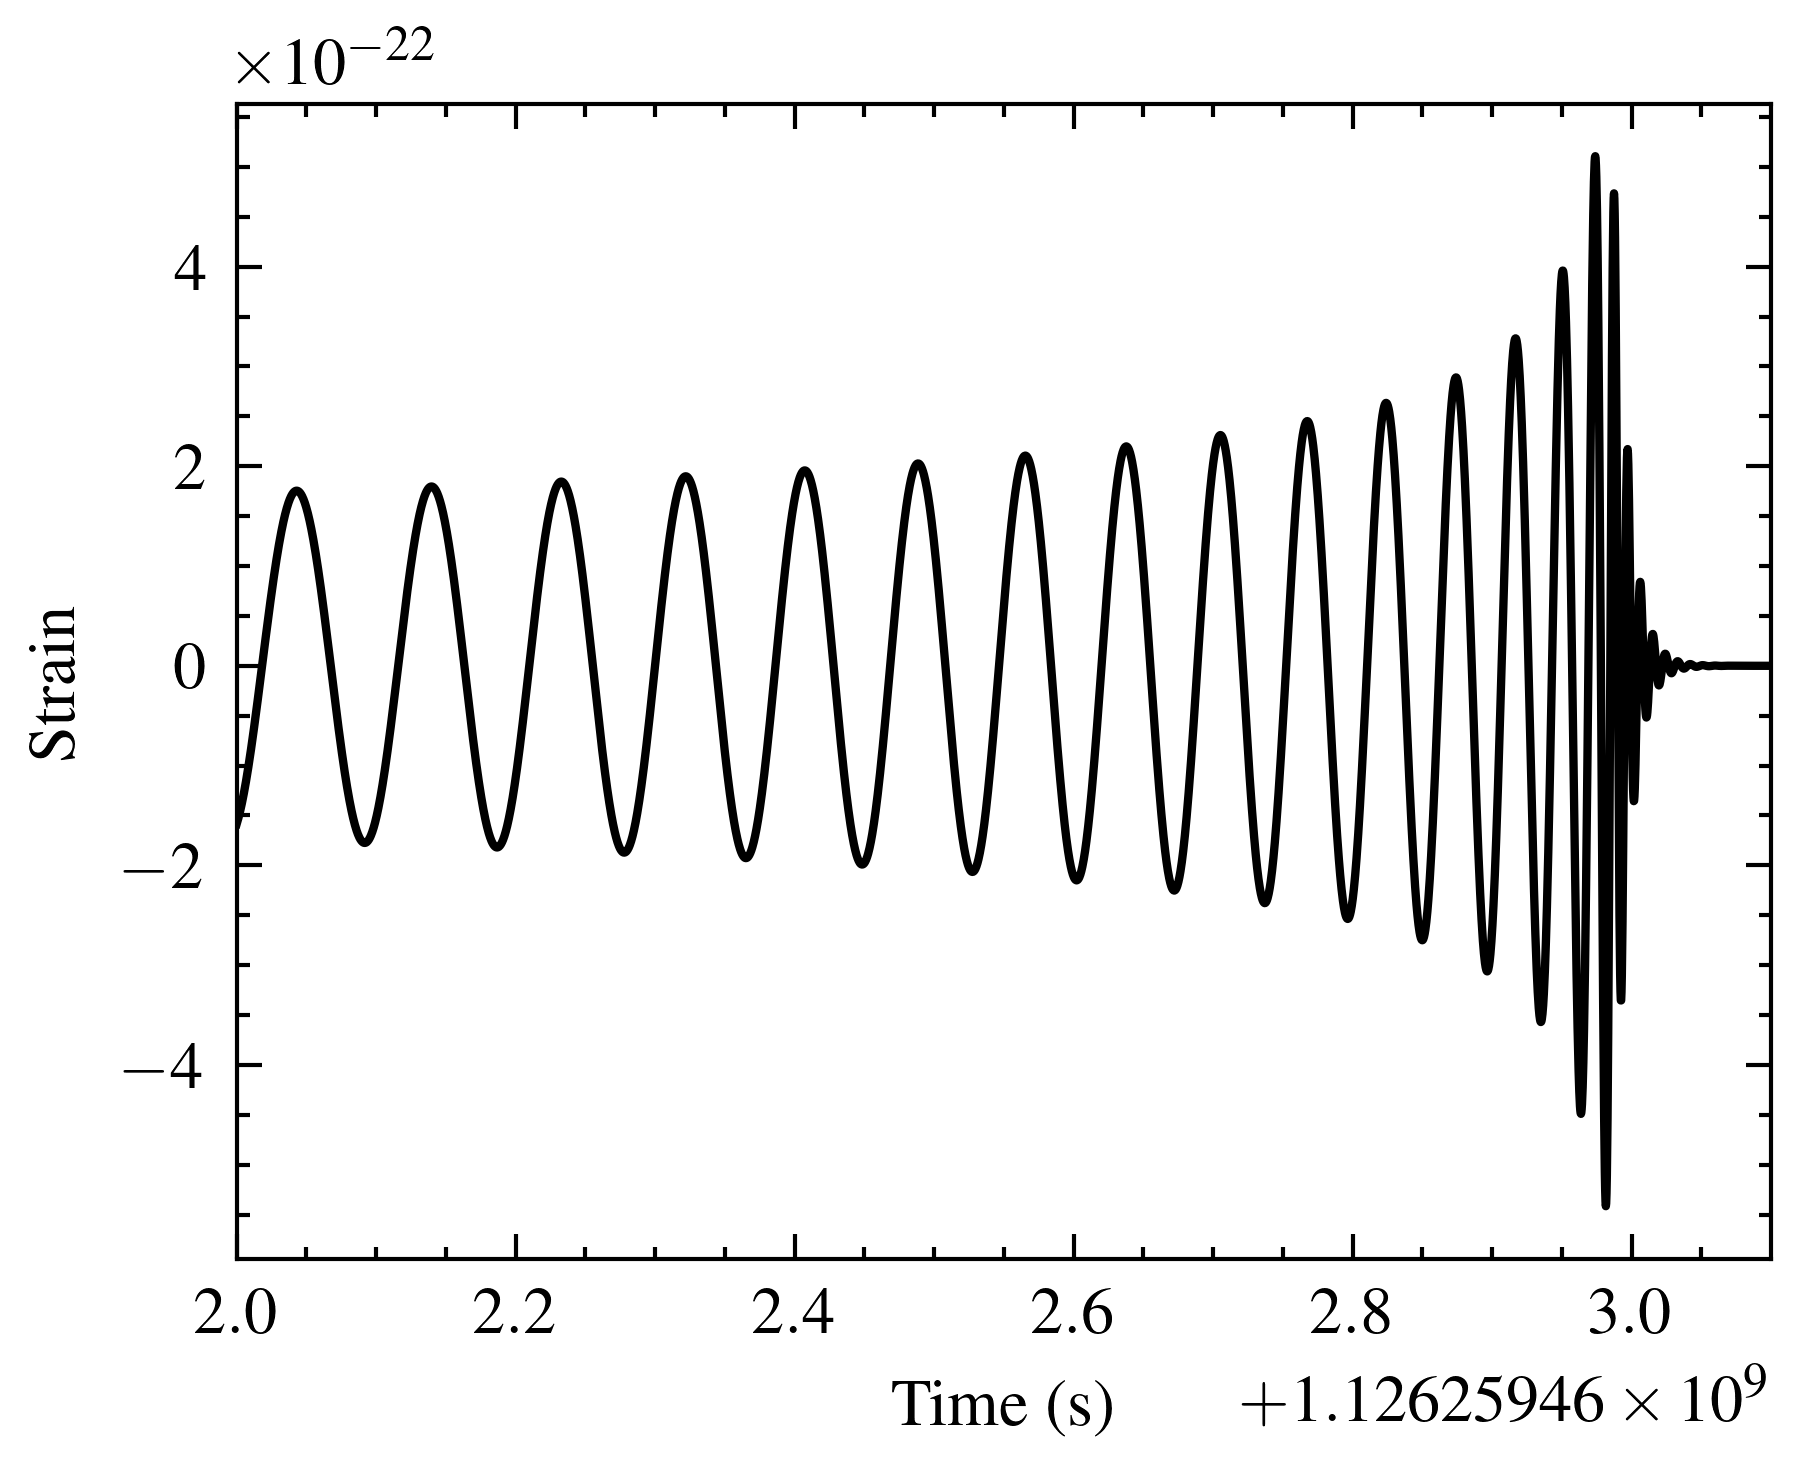

In [101]:
# Plot waveform in time domain
hp, hc = waveform.get_td_waveform(approximant="SEOBNRv4_opt", mass1=80, mass2=80, delta_t=1.0/4096, f_lower=10, distance=2000)
# Set the hp and hc start time to the GPS time
t_gps = 1126259462.0
hp.start_time = hc.start_time = t_gps
# Compute beam pattern functions for a given detector
ifo = "L1"
detector = Detector(ifo)
right_ascension = 1.7
declination = 1.7
polarization = 0.7
# Compute the plus and cross polarizations
fp, fc = detector.antenna_pattern(right_ascension, declination, polarization, t_gps)
h = fp * hp + fc * hc
# Plot the waveform
plt.plot(h.sample_times, h)
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.xlim(t_gps, t_gps + 1.1)
plt.show()

Time domain with whitening

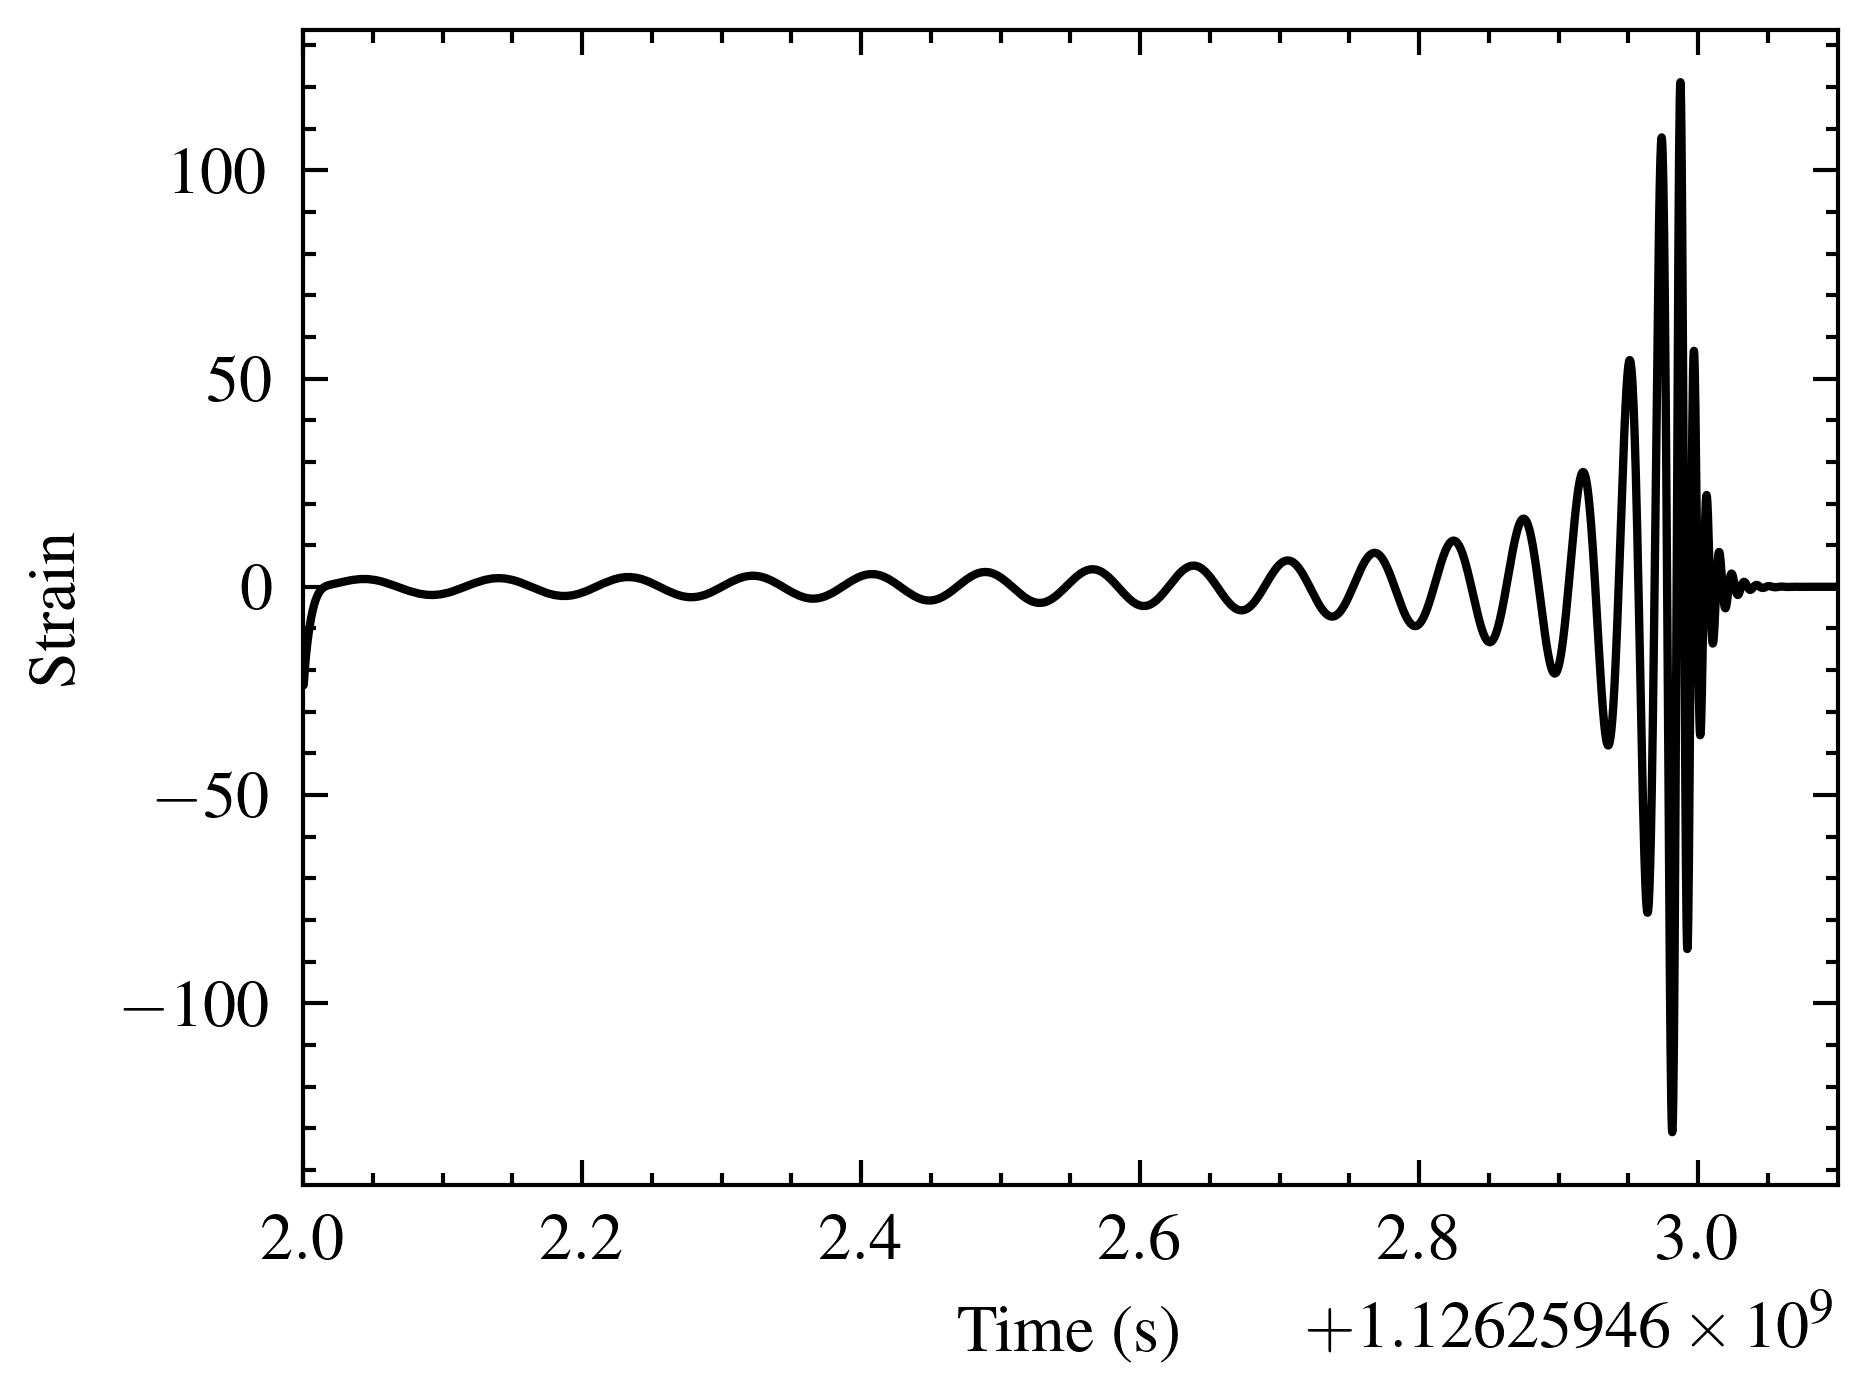

In [103]:
# Transform the waveform to the frequency domain first and then divide out by the PSD
h_frequency = h.to_frequencyseries()
frequencies = h_frequency.sample_frequencies
# Compute the ASD for the detector
# length = int(4096 / 2) + 1
# delta_f = 1.0 / 16
# low_freq_cutoff = 30
length = len(frequencies)
delta_f = frequencies[1] - frequencies[0]
low_freq_cutoff = frequencies[0]
L1_psd = psd.aLIGOZeroDetHighPower(length, delta_f, low_freq_cutoff)
L1_asd = np.sqrt(L1_psd)
assert(np.sum(L1_psd.get_sample_frequencies().data - frequencies.data)==0) # Check that the frequencies match
# Whiten the waveform:
h_whitened_frequency = h_frequency / np.sqrt(L1_psd)
h_whitened_frequency.data[np.isfinite(h_whitened_frequency.data)==False] = 0 # Set NaNs and infs to zero
# Apply hann windowing to the whitened waveform
# import scipy.signal.windows as windows
# window = windows.hann(len(h_whitened_frequency))
# h_whitened_frequency.data *= window
# Transform back to the time domain
h_whitened = h_whitened_frequency.to_timeseries()
# Plot the whitened waveform
plt.plot(h_whitened.sample_times, h_whitened)
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.xlim(t_gps, t_gps + 1.1)
plt.show()

Frequency domain (without whitening)

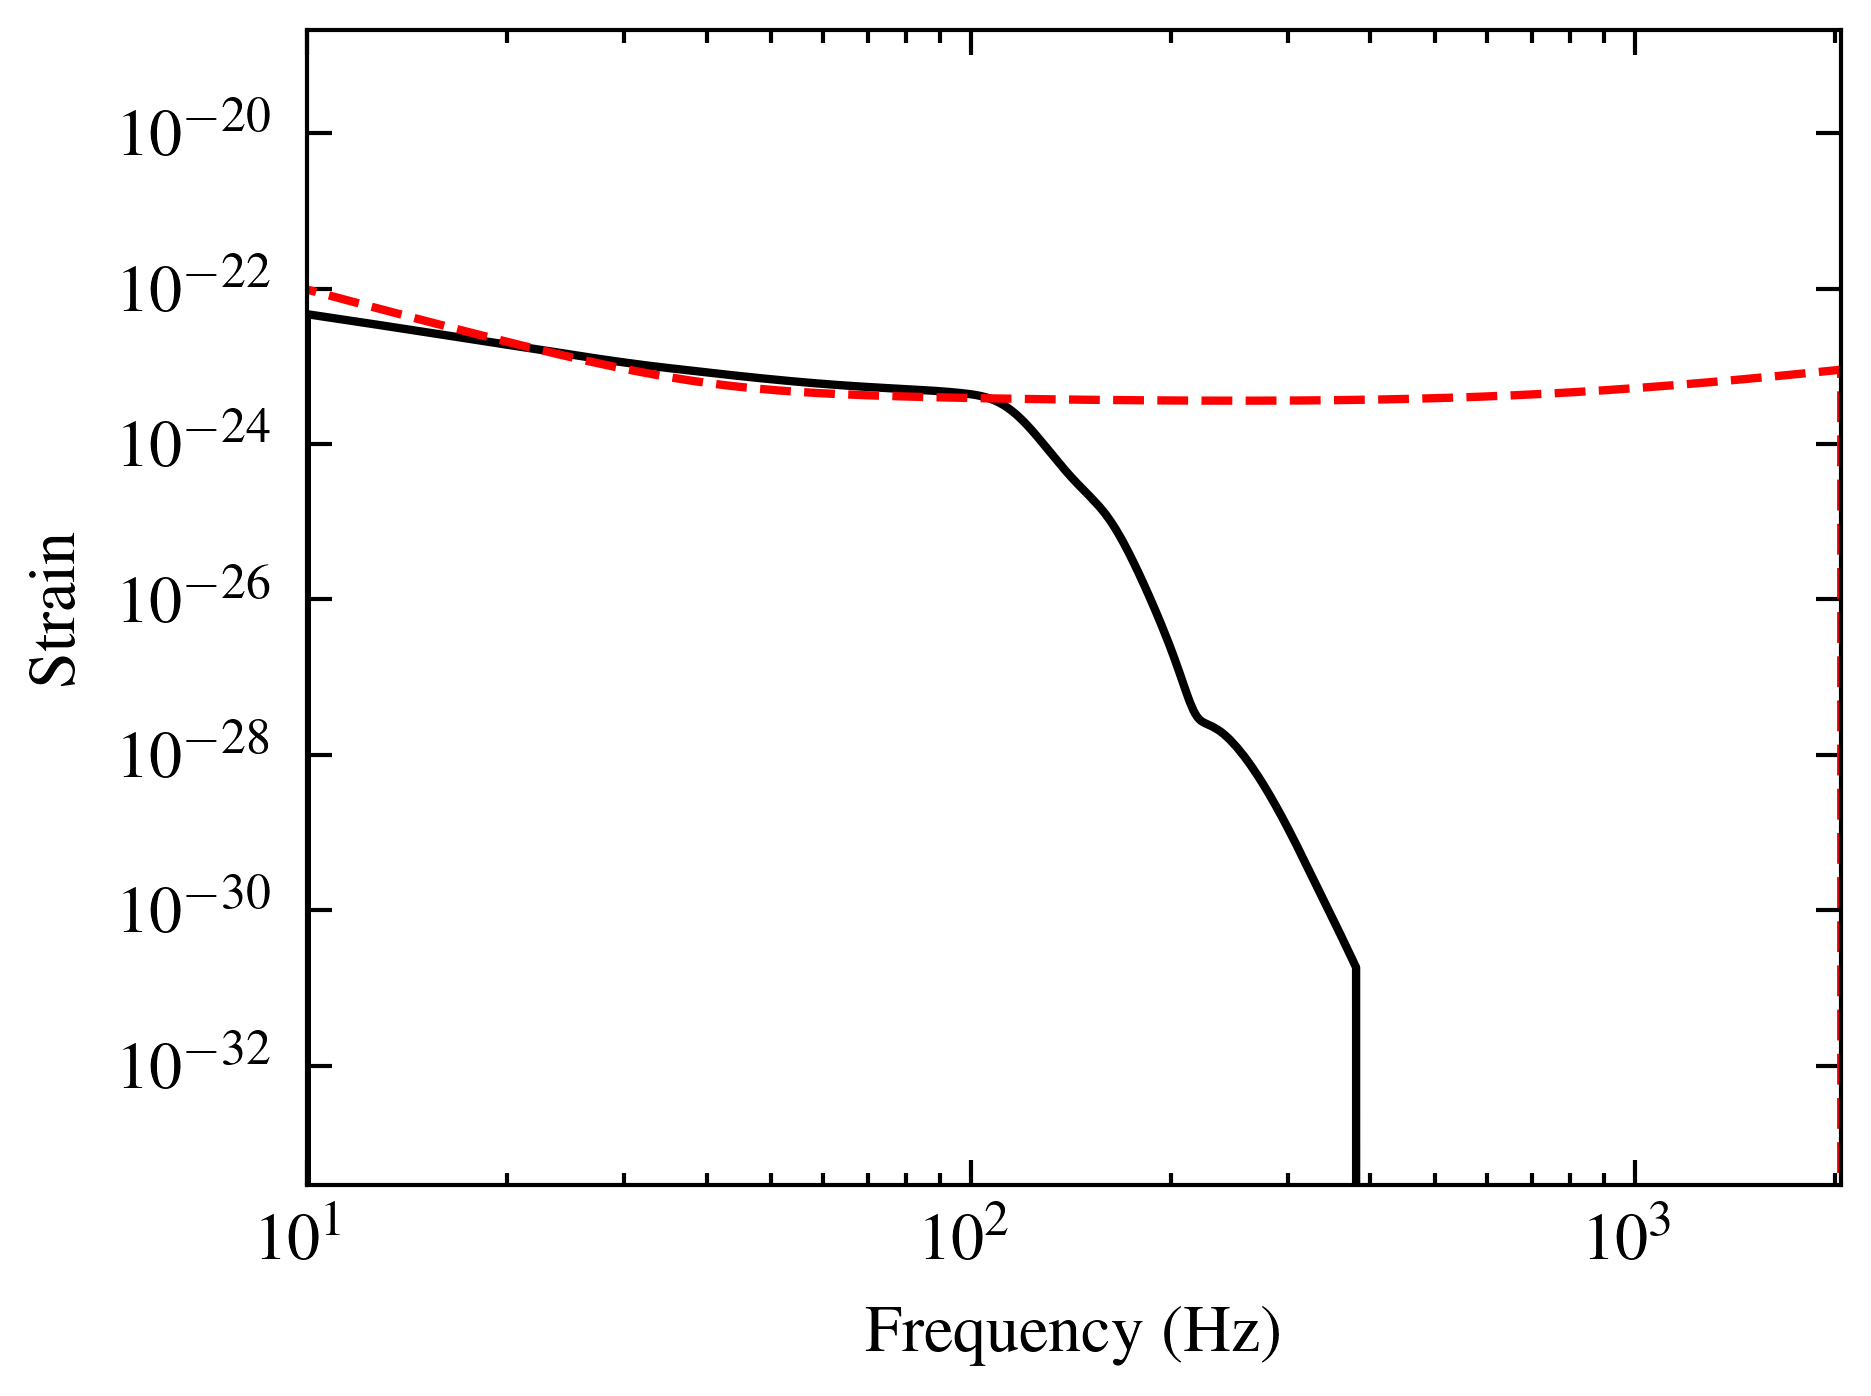

In [104]:
# # Print approximants
# print(waveform.fd_approximants())
hp_freq, hc_freq = waveform.get_fd_waveform(approximant="IMRPhenomXPHM", mass1=80, mass2=80, delta_f=1.0/16, f_lower=10, distance=2000)
# Set the hp and hc start time to the GPS time
hp_freq.start_time = hc_freq.start_time = t_gps
# Compute the plus and cross polarizations
fp, fc = detector.antenna_pattern(right_ascension, declination, polarization, t_gps)
h = fp * hp_freq + fc * hc_freq
# Plot the waveform against asd
plt.plot(h.sample_frequencies, np.abs(h))
plt.plot(L1_psd.sample_frequencies, L1_asd)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Strain')
plt.xlim(10, 2048)
plt.xscale('log')
plt.yscale('log')
plt.show()

# Plot the whitened waveform in frequency domain

In [107]:
L1_psd.get_sample_frequencies().data - h.sample_frequencies.data

ValueError: operands could not be broadcast together with shapes (2640,) (8193,) 